In [1]:
#!pip install yellowbrick
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
import nltk
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import cv2
from sklearn.manifold import TSNE
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.metrics import adjusted_rand_score
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.ticker import FuncFormatter
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

Num GPUs Available:  0


In [2]:
!python --version

# Version des bibliothèques utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))



Python 3.11.5
pandas - 2.0.3
numpy - 1.26.3
seaborn - 0.12.2
nltk - 3.8.1
tensorflow - 2.12.0
cv2 - 4.8.1
gensim - 4.3.0


In [62]:
df=  pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
df.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [64]:
df.sample(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
40,90e56526f4c5892beac49f262b85150a,2016-06-15 04:53:12 +0000,http://www.flipkart.com/mom-kid-baby-girl-s-pr...,Mom and Kid Baby Girl's Printed Green Top & Py...,"[""Baby Care >> Infant Wear >> Baby Girls' Clot...",NSTEJHERS3AKXUCW,999.0,309.0,90e56526f4c5892beac49f262b85150a.jpg,False,Key Features of Mom and Kid Baby Girl's Printe...,No rating available,No rating available,Mom and Kid,"{""product_specification""=>[{""key""=>""Pattern"", ..."
159,219b24362655097cb41bf06a0be8ee79,2015-12-01 12:40:44 +0000,http://www.flipkart.com/prithish-merry-christm...,Prithish Merry Christmas Design 4 Double Color...,"[""Kitchen & Dining >> Coffee Mugs >> Prithish ...",MUGEB7J7SPWJTRDC,599.0,225.0,219b24362655097cb41bf06a0be8ee79.jpg,False,Prithish Merry Christmas Design 4 Double Color...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va..."
76,1971dcd2f3058a4c87bdd7d87d4baeba,2016-03-17 12:56:51 +0000,http://www.flipkart.com/ke-gift-box-stor-jewel...,KE GIFT BOX STOR JEWELLARY Vanity Jewellery,"[""Beauty and Personal Care >> Makeup >> Vanity...",VANEGDV8HEGKHDAQ,400.0,360.0,1971dcd2f3058a4c87bdd7d87d4baeba.jpg,False,Specifications of KE GIFT BOX STOR JEWELLARY V...,No rating available,No rating available,KE,"{""product_specification""=>[{""value""=>""GIFT BOX..."
194,2f756aa2ceb1efda609c428a47308758,2015-12-01 12:40:44 +0000,http://www.flipkart.com/nehp-neh006-showpiece-...,NEHP NEH006 Showpiece - 38.1 cm,"[""Home Decor & Festive Needs >> Showpieces >> ...",SHIEFFFPMFH8SZZM,499.0,499.0,2f756aa2ceb1efda609c428a47308758.jpg,False,Buy NEHP NEH006 Showpiece - 38.1 cm for Rs.4...,No rating available,No rating available,NEHP,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
560,c205b200b10aab43be31df8fc1db6d86,2016-01-07 05:50:25 +0000,http://www.flipkart.com/fastrack-9913pp03-tees...,Fastrack 9913PP03 Tees Analog Watch - For Women,"[""Watches >> Wrist Watches >> Fastrack Wrist W...",WATD9H76YMYPCMCK,649.0,649.0,c205b200b10aab43be31df8fc1db6d86.jpg,True,Fastrack 9913PP03 Tees Analog Watch - For Wom...,2,2,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va..."


In [65]:
df.dtypes.value_counts()

object     12
float64     2
bool        1
Name: count, dtype: int64

In [66]:
df.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

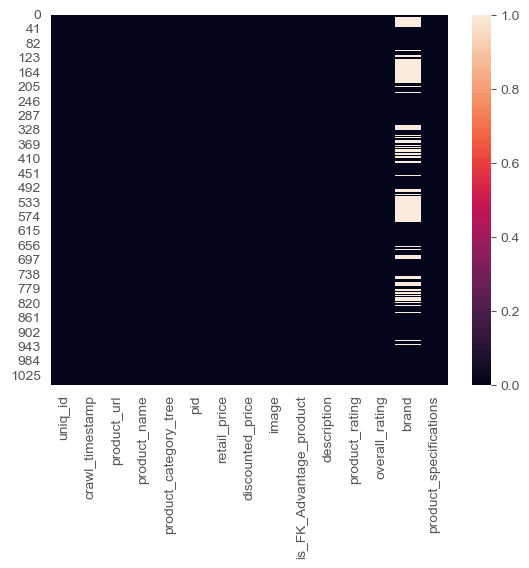

In [67]:
sns.heatmap(df.isnull());

### Traitement de la fonctionnalité "product_category_tree"

In [68]:
df.duplicated(subset="product_category_tree").sum()

408

In [69]:
df_cat = df.groupby('product_category_tree')
df_cat.first()

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
product_category_tree,,,,,,,,,,,,,,
"[""Baby Care >> Baby & Kids Gifts >> Decorations >> Doraemon Gift Family Ceramic Coffee Mug Decorations >> Doraemon Gift Family Ceramic Coffee Mug Multicol...""]",6325bf868b9040a0599f257aba42e9e0,2016-03-03 11:29:08 +0000,http://www.flipkart.com/doraemon-gift-family-c...,Doraemon Gift Family Ceramic Coffee Mug Multic...,DECEG7K7Y3URGWXH,399.0,280.0,6325bf868b9040a0599f257aba42e9e0.jpg,False,Specifications of Doraemon Gift Family Ceramic...,No rating available,No rating available,Doraemon Gift Family Ceramic Coffee Mug,"{""product_specification""=>[{""key""=>""Sales Pack..."
"[""Baby Care >> Baby & Kids Gifts >> Photo Frames >> Cocovey Photo Frames""]",fd10586bf7f01bc57e0c5364d4b2c3f7,2015-12-31 09:19:31 +0000,http://www.flipkart.com/cocovey-metal-photo-fr...,Cocovey Metal Photo Frame,PHFEBZ2GBSK3U43Z,749.0,549.0,fd10586bf7f01bc57e0c5364d4b2c3f7.jpg,False,"Cocovey Metal Photo Frame (Photo Size - 6*4, 1...",No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Stand Mate..."
"[""Baby Care >> Baby & Kids Gifts >> Photo Frames >> Indha Craft Photo Frames""]",6eabdbbbffdfae86c3c5177ba0f96ea7,2015-12-31 09:19:31 +0000,http://www.flipkart.com/indha-craft-cloth-phot...,Indha Craft Cloth Photo Frame,PHFDWUHW25WAWXHY,300.0,132.0,6eabdbbbffdfae86c3c5177ba0f96ea7.jpg,False,Indha Craft Cloth Photo Frame (Photo Size - 12...,No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Stand Mate..."
"[""Baby Care >> Baby & Kids Gifts >> Photo Frames >> MH Photo Frames""]",d06bb04b096c77dc3302eaf2db336f96,2015-12-31 09:19:31 +0000,http://www.flipkart.com/mh-mdf-photo-frame/p/i...,MH MDF Photo Frame,PHFEE9ZQGBXX5NYY,999.0,899.0,d06bb04b096c77dc3302eaf2db336f96.jpg,False,Buy MH MDF Photo Frame for Rs.899 online. MH M...,No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Stand Mate..."
"[""Baby Care >> Baby & Kids Gifts >> Photo Frames >> Wood Beauty Photo Frames""]",f79c9db3abd7faca714c92aeba9b6728,2015-12-31 09:19:31 +0000,http://www.flipkart.com/wood-beauty-photo-fram...,Wood Beauty Wood Photo Frame,PHFEEDJREU4HHEJG,650.0,450.0,f79c9db3abd7faca714c92aeba9b6728.jpg,False,Buy Wood Beauty Wood Photo Frame for Rs.450 on...,No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Frame Mate..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"[""Watches >> Wrist Watches >> Yves Bertelin Wrist Watches >> Yves Bertelin YBSCR557 Analog Watch - For Women""]",4d2e9f36823bad0f6fe8c6b19bb92bdb,2016-04-24 18:34:50 +0000,http://www.flipkart.com/yves-bertelin-ybscr557...,Yves Bertelin YBSCR557 Analog Watch - For Women,WATEHYHJZDVZXNHZ,6950.0,3475.0,4d2e9f36823bad0f6fe8c6b19bb92bdb.jpg,False,Specifications of Yves Bertelin YBSCR557 Analo...,No rating available,No rating available,Yves Bertelin,"{""product_specification""=>[{""key""=>""Mechanism""..."
"[""Watches >> Wrist Watches >> fastrack Wrist Watches""]",653826cd53f1d9e2c086c0ac7846ef70,2015-12-04 07:25:36 +0000,http://www.flipkart.com/fastrack-38015pl01-ana...,"fastrack 38015PL01 Analog Watch - For Men, Boys",WATE9WKSHRYTM2PP,2495.0,2495.0,653826cd53f1d9e2c086c0ac7846ef70.jpg,False,"fastrack 38015PL01 Analog Watch - For Men, Bo...",No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Chronograp..."
"[""Watches >> Wrist Watches >> palito Wrist Watches >> palito PLO 149 Analog Watch - For Girls, Women""]",64a9d0488652194fd8e879d5e6dc8015,2016-04-24 18:34:50 +0000,http://www.flipkart.com/palito-plo-149-analog-...,"palito PLO 149 Analog Watch - For Girls, Women",WATEHZP3ZA9YT99G,1500.0,199.0,64a9d0488652194fd8e879d5e6dc8015.jpg,False,Specifications of palito PLO 149 Analog Watch ...,No rating available,No rating available

In [70]:
#Diviser le contenu de la colonne sur '>>' et récupérer le premier élément = la catégorie principale du produit
df['category'] = df['product_category_tree'].str.split('>>').str.get(0).str.strip()

# Suppression de la ponctuation indésirable de la colonne de catégorie
df['category'] = df['category'].str.extract(r'^\["([^"]+)')

In [71]:
# Real number of product categories 
category_count = df['category'].value_counts()

In [72]:
category_count 

category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

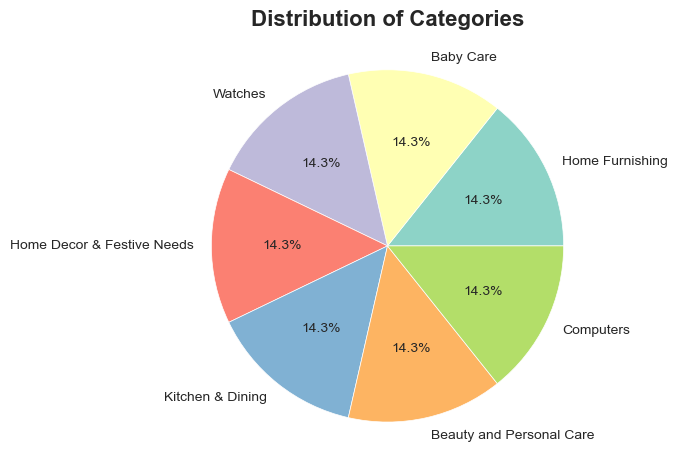

In [73]:
# La distribution par categorie
custom_colors = sns.color_palette('Set3', len(category_count))
plt.figure(figsize=(5, 5))
sns.set_style("whitegrid")
plt.pie(category_count, labels=category_count.index, autopct='%1.1f%%', colors=custom_colors)
plt.title('Distribution of Categories',  fontsize=16, fontweight='bold', pad=20)
plt.axis('equal') 

plt.show()

Il y a sept grandes catégories de produits

## Pre traitement

## Exploration des données


In [74]:
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wall

In [75]:
df_t = df 
df_t.shape

(1050, 16)

In [76]:
df.description.apply(lambda i : len(i))

0       1420
1        444
2       1258
3        858
4       1197
        ... 
1045    2432
1046    1660
1047     262
1048     210
1049     187
Name: description, Length: 1050, dtype: int64

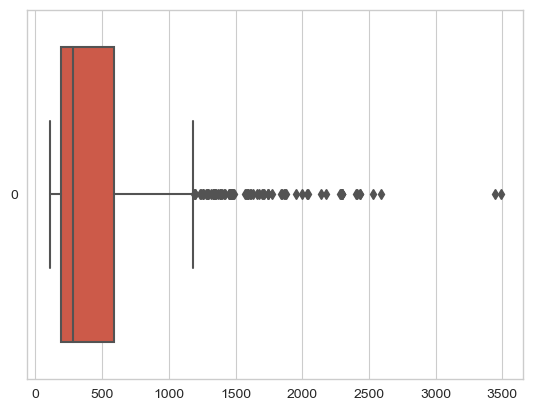

In [77]:
tmp = df.description.str.len()
sns.boxplot(tmp, orient='h');

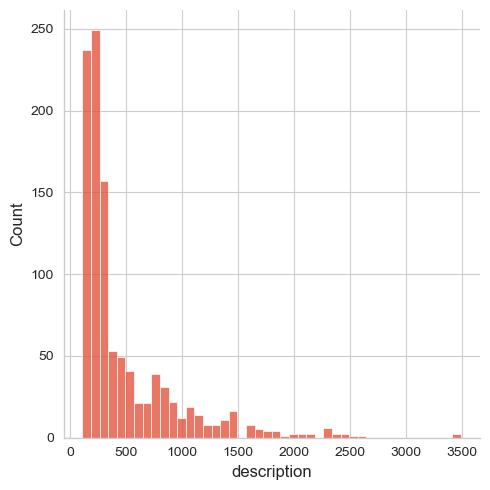

In [78]:
sns.displot(tmp);

In [79]:
df_long = df["_lon_desc"] = tmp
df_long.head(10)

0    1420
1     444
2    1258
3     858
4    1197
5     275
6     268
7     817
8     410
9     430
Name: description, dtype: int64

### Exploration du corpus et des documents

In [80]:
df.head(10)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,_lon_desc
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,1420
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,444
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,1258
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,858
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,1197
5,893aa5ed55f7cff2eccea7758d7a86bd,2015-12-04 07:25:36 +0000,http://www.flipkart.com/maserati-time-r8851116...,Maserati Time R8851116001 Analog Watch - For ...,"[""Watches >> Wrist Watches >> Maserati Time Wr...",WATEAYAHJ8CUCAYM,24400.0,24400.0,893aa5ed55f7cff2eccea7758d7a86bd.jpg,False,Maserati Time R8851116001 Analog Watch - For ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,275
6,f355cc1ccb08bd0d283ed979b7ee7515,2015-12-04 07:25:36 +0000,http://www.flipkart.com/camerii-wm64-elegance-...,"Camerii WM64 Elegance Analog Watch - For Men,...","[""Watches >> Wrist Watches >> Camerii Wrist Wa...",WATE6Y6D2MZHWGBZ,1099.0,449.0,f355cc1ccb08bd0d283ed979b7ee7515.jpg,False,"Camerii WM64 Elegance Analog Watch - For Men,...",5,5,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,268
7,dd0e3470a7e6ed76fd69c2da27721041,2015-12-04 07:25:36 +0000,http://www.flipkart.com/t-star-uft-tsw-005-bk-...,T STAR UFT-TSW-005-BK-BR Analog Watch - For Boys,"[""Watches >> Wrist Watches >> T STAR Wrist Wat...",WATECFFVGFZPAD3D,999.0,399.0,dd0e3470a7e6ed76fd69c2da27721041.jpg,False,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,817
8,41384da51732c0b4df3de8f395714fbb,2015-12-04 07:25:36 +0000,http://www.flipkart.com/alfajr-wy16b-youth-dig...,"Alfajr WY16B Youth Digital Watch - For Men, Boys","[""Watches >

In [81]:
df_samp = df.sample(10)
df_samp

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,_lon_desc
433,32f24a4303050f500dec7cb3608fe089,2016-03-11 06:55:07 +0000,http://www.flipkart.com/smartpro-19-5v-3-9a-re...,"Smartpro 19.5v,3.9a Replacement Charger for Va...","[""Computers >> Laptop Accessories >> Adapters ...",ACCEGZ6BY4ZPBWWV,1499.0,539.0,32f24a4303050f500dec7cb3608fe089.jpg,False,"Key Features of Smartpro 19.5v,3.9a Replacemen...",No rating available,No rating available,Smartpro,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Computers,2297
473,ba9f3a5ab1517a644322d856a7d25946,2016-04-16 13:01:18 +0000,http://www.flipkart.com/allin-exporters-fennel...,Allin Exporters Fennel Oil (Co2 Extract),"[""Beauty and Personal Care >> Bath and Spa >> ...",BEOEGXRVQPCKJHYC,649.0,649.0,ba9f3a5ab1517a644322d856a7d25946.jpg,False,Key Features of Allin Exporters Fennel Oil (Co...,No rating available,No rating available,Allin Exporters,"{""product_specification""=>[{""value""=>""Essentia...",Beauty and Personal Care,1017
199,90f86ac4065397340e8012261577c220,2015-12-01 12:40:44 +0000,http://www.flipkart.com/step4deal-wheel-pizza-...,Step4deal Wheel Pizza Cutter,"[""Kitchen & Dining >> Kitchen Tools >> Kitchen...",PACEAU9GVDACRKUV,499.0,139.0,90f86ac4065397340e8012261577c220.jpg,False,Step4deal Wheel Pizza Cutter (Stainless Steel ...,No rating available,No rating available,Step4deal,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Kitchen & Dining,750
96,f12a06b7dbfc55638afafcf8bb03d836,2016-01-04 00:20:04 +0000,http://www.flipkart.com/my-angel-gifts-show-pi...,My Angel Gifts Show Piece Showpiece - 5 cm,"[""Home Decor & Festive Needs >> Table Decor & ...",SHIEAVZQQUWKYURZ,1299.0,1149.0,f12a06b7dbfc55638afafcf8bb03d836.jpg,False,Buy My Angel Gifts Show Piece Showpiece - 5 ...,No rating available,No rating available,My Angel,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Decor & Festive Needs,220
321,5df72b5295dc5e6126693e640b50f3a2,2015-12-01 06:13:00 +0000,http://www.flipkart.com/apple-md199hn-a/p/itme...,Apple MD199HN/A,"[""Computers >> Network Components >> Routers >...",RTREBZRG4SE4AFBX,5900.0,5900.0,5df72b5295dc5e6126693e640b50f3a2.jpg,False,Buy Apple MD199HN/A only for Rs. 5900 from Fli...,No rating available,No rating available,Apple,"{""product_specification""=>[{""key""=>""Wireless S...",Computers,142
216,2110699b945ae766c8b8112038ac58b9,2015-12-01 12:40:44 +0000,http://www.flipkart.com/go-hooked-wheel-pizza-...,Go Hooked Wheel Pizza Cutter,"[""Kitchen & Dining >> Kitchen Tools >> Kitchen...",PACE5VYX8NDTBXK4,450.0,199.0,2110699b945ae766c8b8112038ac58b9.jpg,False,Buy Go Hooked Wheel Pizza Cutter for Rs.199 on...,No rating available,No rating available,Go Hooked,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Kitchen & Dining,187
958,2476ae5a5e045876aa08f5919cb3b91b,2016-03-18 08:01:41 +0000,http://www.flipkart.com/m-s-rugs-pink-blue-woo...,"M S Rugs Pink, Blue Wool Dhurrie","[""Home Furnishing >> Floor Coverings >> Carpet...",CPGEGVXAQUV6RF6J,5300.0,3100.0,2476ae5a5e045876aa08f5919cb3b91b.jpg,False,"Key Features of M S Rugs Pink, Blue Wool Dhurr...",No rating available,No rating available,M S Rugs,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,487
879,fc976caafdebbab15560dad48bc6ff0f,2015-12-20 08:26:17 +0000,http://www.flipkart.com/casa-copenhagen-set-to...,Casa Copenhagen Set of Towels,"[""Home Furnishing >> Bath Linen >> Towels""]",BTWE4GQS9TZHKHY4,800.0,800.0,fc976caafdebbab15560dad48bc6ff0f.jpg,False,Buy Casa Copenhagen Set of Towels at Rs. 800 a...,No rating available,No rating available,Casa Copenhagen,"{""product_specification""=>[{""key""=>""Design"", ""...",Home Furnishing,117
1042,057836ecde71565f8ebdd576e41fdc96,2015-12-01 10:15:43 +0000,http://www.flipkart.com/walldesign-small-vinyl...,WallDesign Small Vinyl Sticker,"[

In [82]:
for idx, ser in df_samp.iterrows():
    id_prod = f": {ser['uniq_id']}\n"
    print( id_prod + ser["description"]+ "..." +"\n\n")

: 32f24a4303050f500dec7cb3608fe089
Key Features of Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR305E/L 75 Adapter Designed  for Sony  Vaio VGN-CR305E/L,Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR305E/L 75 Adapter (Power Cord Included) Price: Rs. 599 This is a SmartPro Brand Product. Smartpro Laptop Adapter For 75W Charger for Sony Vaio VGN-CR305E/L 19.5V 3.9A 19.5V 3.95A Connector Pin Size 6.5 x 4.4. This Smartpro replacement adapter is designed to provide reliable power and charge to your laptop. Made from highest quality parts each replacement adapter conforms to specifications similar to original in its quality. Each adapter also passes necessary authentication certifications like CE, ROHS etc. Before leaving the factory, so you can be rest assured for its quality, durability and performance. Please note that all images are indicative, actual product label may vary. Before place order the adapter please assure that you have select right adapter fo

In [83]:
df_samp0 = df.sample(10)
df_samp0

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,_lon_desc
624,e10cbc680042d27fb747db2ac8e7a585,2016-06-16 23:45:04 +0000,http://www.flipkart.com/oxolloxo-solid-single-...,Oxolloxo Solid Single Breasted Casual Women's ...,"[""Baby Care >> Infant Wear >> Baby Boys' Cloth...",BZREJH9PC4Z7RGUS,1699.0,1699.0,e10cbc680042d27fb747db2ac8e7a585.jpg,False,Specifications of Oxolloxo Solid Single Breast...,No rating available,No rating available,Oxolloxo,"{""product_specification""=>[{""key""=>""Pattern"", ...",Baby Care,389
774,093bcad64d11c0aed903a8dd787ef069,2015-12-12 11:46:53 +0000,http://www.flipkart.com/offspring-embroidered-...,"Offspring Embroidered, Solid Single Wrapper Wh...","[""Baby Care >> Baby Bedding >> Baby Blankets >...",BLAE8B5G4GWTBEEH,399.0,310.0,093bcad64d11c0aed903a8dd787ef069.jpg,False,"Offspring Embroidered, Solid Single Wrapper Wh...",No rating available,No rating available,Offspring,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Baby Care,410
636,a378736c1510a13966b42c2d6462f526,2016-06-07 14:06:00 +0000,http://www.flipkart.com/jacadi-paris-baby-girl...,Jacadi Paris Baby Girl's Gathered Blue Dress,"[""Baby Care >> Infant Wear >> Baby Girls' Clot...",DREEJFHXDWUFDFFV,6099.0,6099.0,a378736c1510a13966b42c2d6462f526.jpg,False,Key Features of Jacadi Paris Baby Girl's Gathe...,No rating available,No rating available,Jacadi Paris,"{""product_specification""=>[{""value""=>""1 cotton...",Baby Care,665
53,6329ddb46087cb8c09ced95471dd9643,2016-06-17 11:45:06 +0000,http://www.flipkart.com/jrb-1038-smallest-mobi...,JRB 1038 Smallest Mobile Powered By OTG Enable...,"[""Computers >> Laptop Accessories >> USB Gadge...",USGEJPQKBNS5KDTE,499.0,249.0,6329ddb46087cb8c09ced95471dd9643.jpg,False,Key Features of JRB 1038 Smallest Mobile Power...,No rating available,No rating available,JRB,"{""product_specification""=>nil}",Computers,553
166,d19d17140fdd9adc09ba6e2ad1e1ebb9,2015-12-01 12:40:44 +0000,http://www.flipkart.com/prithish-happy-birthda...,Prithish Happy Birthday Ceramic Mug,"[""Kitchen & Dining >> Coffee Mugs >> Prithish ...",MUGE75ZZ3G2NGKXZ,499.0,175.0,d19d17140fdd9adc09ba6e2ad1e1ebb9.jpg,False,Buy Prithish Happy Birthday Ceramic Mug for Rs...,5,5,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va...",Kitchen & Dining,201
615,5ea8ddb8a5104c5d47c708e8a351e701,2016-06-21 02:47:15 +0000,http://www.flipkart.com/boreal-plastic-rectang...,Boreal Plastic rectangular hair brush 633D,"[""Baby Care >> Baby Grooming >> Boreal Baby Gr...",HRBEHPGUHFBJ8GKD,395.0,395.0,5ea8ddb8a5104c5d47c708e8a351e701.jpg,False,Specifications of Boreal Plastic rectangular h...,No rating available,No rating available,Boreal,"{""product_specification""=>[{""key""=>""Brush Type...",Baby Care,417
583,35a68b44bef47a809314493d28535b9d,2016-01-07 05:50:25 +0000,http://www.flipkart.com/timewel-1100-n1944-b-a...,Timewel 1100-N1944_B Analog Watch - For Women,"[""Watches >> Wrist Watches >> Timewel Wrist Wa...",WATE2FAGESM5B5VZ,855.0,855.0,35a68b44bef47a809314493d28535b9d.jpg,False,Timewel 1100-N1944_B Analog Watch - For Women...,5,5,NaN,"{""product_specification""=>[{""key""=>""Mechanism""...",Watches,266
400,4fe24e100a5fcc33cf6054ef101067ed,2015-12-01 06:13:00 +0000,http://www.flipkart.com/tp-link-td-w8970/p/itm...,TP-LINK TD-W8970,"[""Computers >> Network Components >> Routers >...",RTRDXV6BA5PZAEPH,6700.0,4850.0,4fe24e100a5fcc33cf6054ef101067ed.jpg,True,Buy TP-LINK TD-W8970 only for Rs. 5050 from Fl...,3,3,TP-LINK,"{""product_specification""=>[{""key""=>""Wireless S...",Computers,143
771,42643c1c9403f67921a18654bcf45ead,2015-12-12 11:46:53 +0000,http://www.flipkart.com/offspring-printed-sing...,Offspring Printed Single Blanket Blue,"[""Baby Care >> Baby Bedding >> Baby Blankets >...",BLAE8BUKZ9SMGSDW,399.0,305.0,42643c1c9403f67921a18654bcf45ead.jpg,False,Offspring Printed Sing

### Nettoyage de la fonctionalité "description"
### Bag of word

In [84]:
import re, nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [85]:
def cleaned_text(text):
    clean = re.sub("\n"," ",text)
    clean=clean.lower()
    clean=re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
    clean=re.sub("[^a-z]"," ",clean)
    clean=clean.lstrip()
    clean=re.sub("\s{2,}"," ",clean)
    return clean
df_t["cleaned_description"]=df_t["description"].apply(cleaned_text)

In [86]:
df_t["cleaned_description"] = df_t["cleaned_description"].apply(lambda x: ' '.join([word for word in x.split() if len(word)>3]))

In [87]:
 df_t["cleaned_description"].head(10)

0    features elegance polyester multicolor abstrac...
1    specifications sathiyas cotton bath towel bath...
2    features eurospa cotton terry face towel size ...
3    features santosh royal fashion cotton printed ...
4    features jaipur print cotton floral king sized...
5    maserati time analog watch boys maserati time ...
6    camerii elegance analog watch boys camerii ele...
7    star analog watch boys price whether your work...
8    alfajr youth digital watch boys alfajr youth d...
9    heuer formula analog watch boys heuer formula ...
Name: cleaned_description, dtype: object

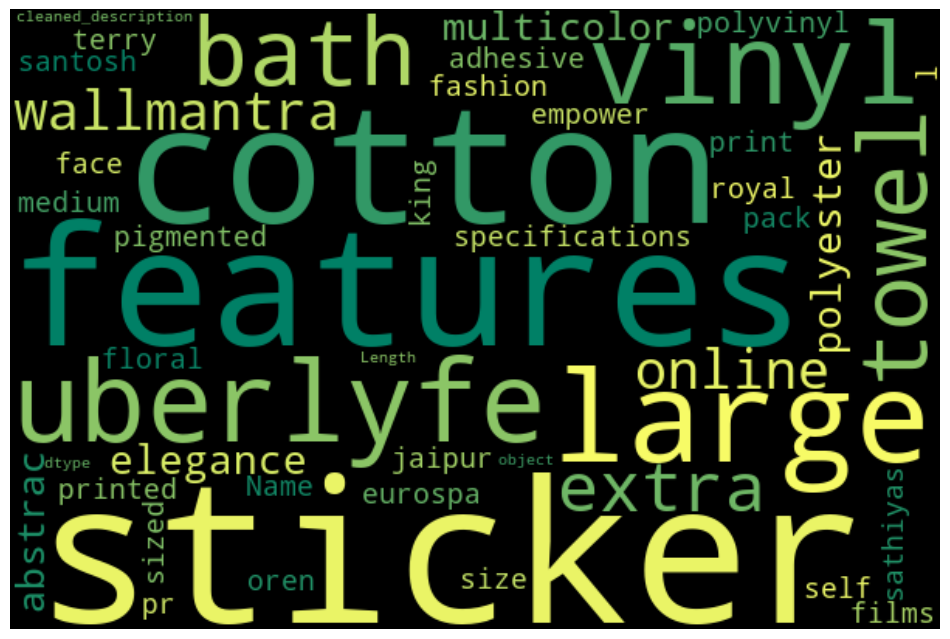

In [88]:
cloud=WordCloud(colormap="summer",width=600,height=400).generate(str(df_t["cleaned_description"]))
fig=plt.figure(figsize=(12,9))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear');

In [89]:
stop=stopwords.words('english')
stop.append("also")
df_t["stop_removed_description"]=df_t["cleaned_description"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [90]:
df_t["tokenized"]=df_t["stop_removed_description"].apply(lambda x: nltk.word_tokenize(x))

In [91]:
df_t["tokenized"]

0       [features, elegance, polyester, multicolor, ab...
1       [specifications, sathiyas, cotton, bath, towel...
2       [features, eurospa, cotton, terry, face, towel...
3       [features, santosh, royal, fashion, cotton, pr...
4       [features, jaipur, print, cotton, floral, king...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046    [wallmantra, large, vinyl, sticker, sticker, p...
1047    [uberlyfe, extra, large, pigmented, polyvinyl,...
1048    [wallmantra, medium, vinyl, sticker, sticker, ...
1049    [uberlyfe, large, vinyl, sticker, online, uber...
Name: tokenized, Length: 1050, dtype: object

### Lemmatization

In [92]:
from nltk.stem import WordNetLemmatizer 

In [93]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
    return lem_text
df_t["lemmatized"]=df_t["tokenized"].apply(lambda x: word_lemmatizer(x))
df_t["lemmatize_joined"]=df_t["lemmatized"].apply(lambda x: ' '.join(x))

In [94]:
df_t["lemmatize_joined"].head()

0    feature elegance polyester multicolor abstract...
1    specifications sathiyas cotton bath towel bath...
2    feature eurospa cotton terry face towel size s...
3    feature santosh royal fashion cotton print kin...
4    feature jaipur print cotton floral king size d...
Name: lemmatize_joined, dtype: object

In [95]:
df_t['Nombre de mots après nettoyage'] = df_t['lemmatize_joined'].apply(lambda x:len(str(x).split()))

In [96]:
df_t

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,brand,product_specifications,category,_lon_desc,cleaned_description,stop_removed_description,tokenized,lemmatized,lemmatize_joined,Nombre de mots après nettoyage
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,1420,features elegance polyester multicolor abstrac...,features elegance polyester multicolor abstrac...,"[features, elegance, polyester, multicolor, ab...","[feature, elegance, polyester, multicolor, abs...",feature elegance polyester multicolor abstract...,141
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,444,specifications sathiyas cotton bath towel bath...,specifications sathiyas cotton bath towel bath...,"[specifications, sathiyas, cotton, bath, towel...","[specifications, sathiyas, cotton, bath, towel...",specifications sathiyas cotton bath towel bath...,55
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,1258,features eurospa cotton terry face towel size ...,features eurospa cotton terry face towel size ...,"[features, eurospa, cotton, terry, face, towel...","[feature, eurospa, cotton, terry, face, towel,...",feature eurospa cotton terry face towel size s...,131
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,858,features santosh royal fashion cotton printed ...,features santosh royal fashion cotton printed ...,"[features, santosh, royal, fashion, cotton, pr...","[feature, santosh, royal, fashion, cotton, pri...",feature santosh royal fashion cotton print kin...,102
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,1197,features jaipur print cotton floral king sized...,features jaipur print cotton floral king sized...,"[features, jaipur, print, cotton, floral, king...","[feature, jaipur, print, cotton, floral, king,...",feature jaipur print cotton floral king size d...,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,...,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,2432,oren empower extra large self adhesive sticker...,oren empower extra large self adhesive s

In [97]:
df_t.to_csv('df_t.csv', index=False)

In [98]:
df_t

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,brand,product_specifications,category,_lon_desc,cleaned_description,stop_removed_description,tokenized,lemmatized,lemmatize_joined,Nombre de mots après nettoyage
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,1420,features elegance polyester multicolor abstrac...,features elegance polyester multicolor abstrac...,"[features, elegance, polyester, multicolor, ab...","[feature, elegance, polyester, multicolor, abs...",feature elegance polyester multicolor abstract...,141
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,444,specifications sathiyas cotton bath towel bath...,specifications sathiyas cotton bath towel bath...,"[specifications, sathiyas, cotton, bath, towel...","[specifications, sathiyas, cotton, bath, towel...",specifications sathiyas cotton bath towel bath...,55
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,1258,features eurospa cotton terry face towel size ...,features eurospa cotton terry face towel size ...,"[features, eurospa, cotton, terry, face, towel...","[feature, eurospa, cotton, terry, face, towel,...",feature eurospa cotton terry face towel size s...,131
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,858,features santosh royal fashion cotton printed ...,features santosh royal fashion cotton printed ...,"[features, santosh, royal, fashion, cotton, pr...","[feature, santosh, royal, fashion, cotton, pri...",feature santosh royal fashion cotton print kin...,102
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,1197,features jaipur print cotton floral king sized...,features jaipur print cotton floral king sized...,"[features, jaipur, print, cotton, floral, king...","[feature, jaipur, print, cotton, floral, king,...",feature jaipur print cotton floral king size d...,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,...,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,2432,oren empower extra large self adhesive sticker...,oren empower extra large self adhesive s

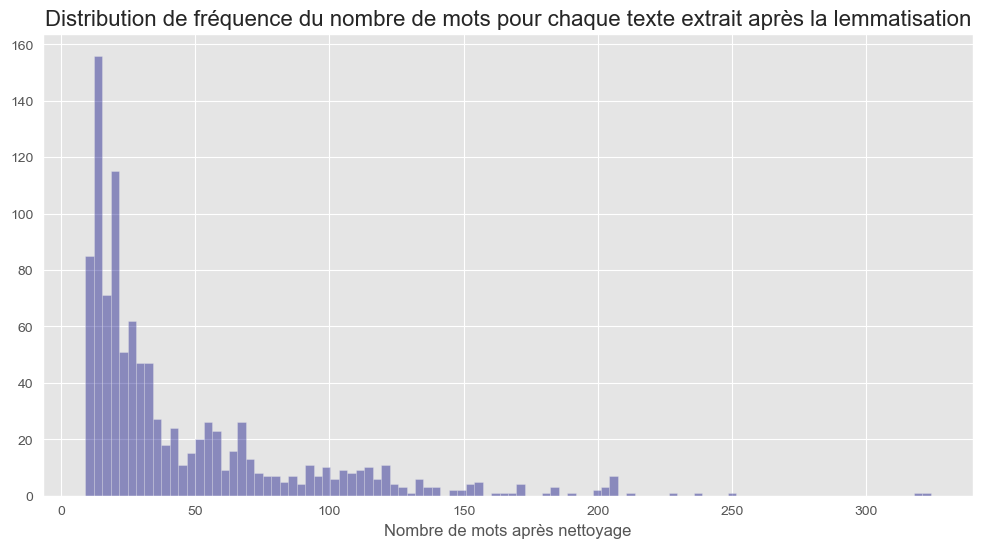

In [99]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df_t['Nombre de mots après nettoyage'],kde = False, color= "navy", bins = 100)
plt.title("Distribution de fréquence du nombre de mots pour chaque texte extrait après la lemmatisation", size=16);

In [100]:
df_t.drop(df_t[df_t["Nombre de mots après nettoyage"]>300].index, inplace = True)

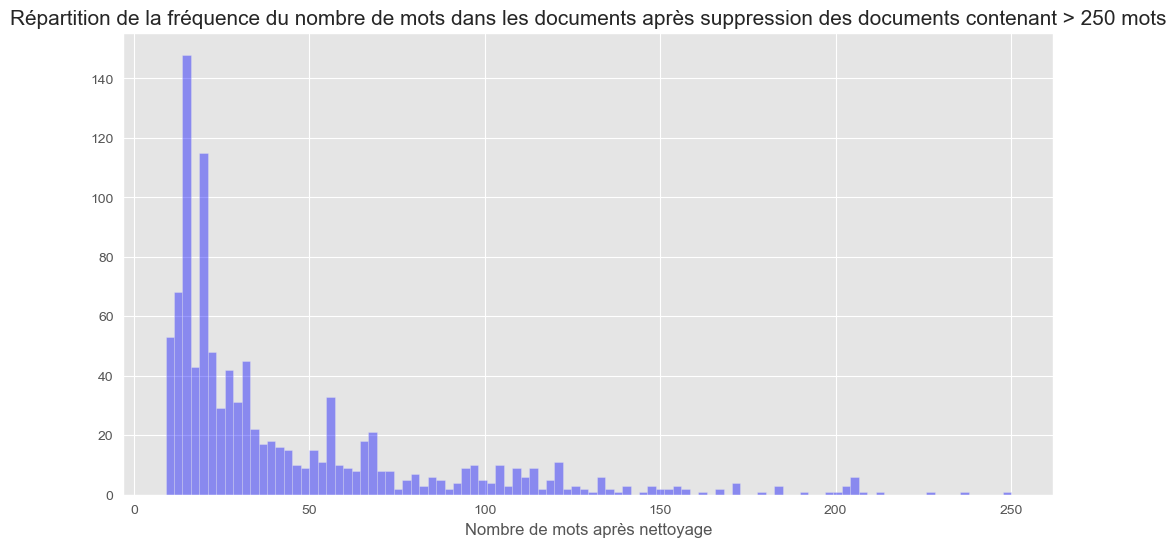

In [101]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df_t['Nombre de mots après nettoyage'],kde = False, color= "blue", bins = 100)
plt.title("Répartition de la fréquence du nombre de mots dans les documents après suppression des documents contenant > 250 mots", size=15);

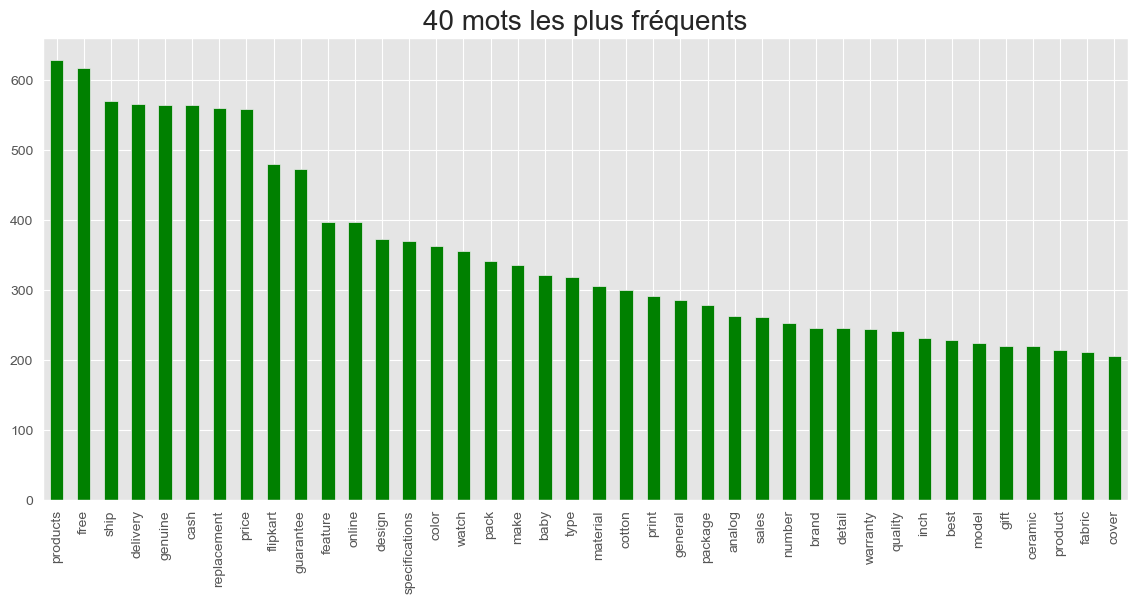

In [102]:
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
freq=pd.Series(" ".join(df_t["lemmatize_joined"]).split()).value_counts()[:40]
freq.plot(kind="bar", color = "green")
plt.title("40 mots les plus fréquents",size=20);

### Tf-idf

## NLP   
### TF-IDF (Term frequency-inverse document frequency)

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
from gensim.models import Word2Vec
import itertools
import tensorflow as tf


In [104]:
from string import punctuation
from nltk.corpus import stopwords
stopwords_en = set(["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"])
stopwords_nltk = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
stopwords_combined = set.union(stopwords_en, stopwords_nltk, stopwords_punct)

In [105]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
     def __init__(self):
         self.wnl = WordNetLemmatizer()
        
     def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

tfidf = TfidfVectorizer(encoding='utf-8',
                       lowercase=True,
                       tokenizer=LemmaTokenizer(),
                       stop_words=stopwords_combined,
                       )

In [106]:
tfidf = TfidfVectorizer()
 
# get tf-df values
result = tfidf.fit_transform(df_t["description"])

In [107]:
# display tf-idf values
print('\ntf-idf value:')
print(result)


tf-idf value:
  (0, 3574)	0.02435118531699746
  (0, 2012)	0.028231536843717507
  (0, 1279)	0.03463120725266925
  (0, 4047)	0.047392208123346664
  (0, 4765)	0.047392208123346664
  (0, 1769)	0.027631362017021478
  (0, 3909)	0.02378080899306603
  (0, 1317)	0.0225107899230491
  (0, 3371)	0.034095824079673556
  (0, 2063)	0.027503127000571684
  (0, 1664)	0.02382345467055865
  (0, 2180)	0.06705250833395213
  (0, 3015)	0.0364533820607544
  (0, 4871)	0.026594252177580834
  (0, 3818)	0.031214911825098335
  (0, 3694)	0.05462810674834151
  (0, 5598)	0.02348768047602811
  (0, 2577)	0.011827470124136853
  (0, 2013)	0.0364533820607544
  (0, 1330)	0.024261108770697478
  (0, 2692)	0.0213290503952278
  (0, 5120)	0.019910474036639328
  (0, 5283)	0.06705250833395213
  (0, 916)	0.06065283792500038
  (0, 4661)	0.0484493666071762
  :	:
  (1047, 5603)	0.5643396287255084
  (1047, 5728)	0.400359677351323
  (1047, 5190)	0.400359677351323
  (1047, 3328)	0.42656889073766247
  (1047, 4353)	0.108132476015503
  (104

In [108]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(df_t["lemmatize_joined"])
final_tf_idf.shape

(1048, 3986)

In [109]:
finalScore = df_t['category']
finalScore

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: category, Length: 1048, dtype: object

In [110]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [111]:
count_vect = CountVectorizer() #in scikit-learn
final_counts_bow = count_vect.fit_transform(df_t["lemmatize_joined"])
final_counts_bow.shape

(1048, 3986)

In [112]:
type(final_counts_bow)

scipy.sparse._csr.csr_matrix

In [113]:
final_counts_bow

<1048x3986 sparse matrix of type '<class 'numpy.int64'>'
	with 29004 stored elements in Compressed Sparse Row format>

In [114]:
ndatapoints=1000
data = final_counts_bow[0:ndatapoints,:]
labels = finalScore[0:ndatapoints]

In [115]:
data

<1000x3986 sparse matrix of type '<class 'numpy.int64'>'
	with 27164 stored elements in Compressed Sparse Row format>

In [116]:
data = np.asarray(data)

In [ ]:
# Converting sparce to dense metrics to standardize the data
data_dense=df_t.todense()
#Standardizing the data
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(data_dense)
standardized_data.shape

### t-SNE visualization for TF-IDF

In [ ]:
tsne_visualize(standardized_data,labels)

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [123]:
# Converting each sequence of words into a single string
corpus = df['lemmatized'].apply(' '.join).values.astype('U')

# Defining the vectorizer
vectorizer = TfidfVectorizer()

# Fitting it to the string 
vectorizer.fit(corpus)

# Transforming the corpus into a TF-IDF matrix
tfidf_matrix = vectorizer.transform(corpus)

# Converting the TF-IDF matrix to a df
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

In [124]:
df_tfidf

,aapno,aari,aarika,abide,abilities,ability,abkl,able,abroad,absolute,...,zero,zikrak,zinc,zingalalaa,zipexterior,zipper,zone,zoom,zora,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
df_tfidf.isnull().sum()

aapno        0
aari         0
aarika       0
abide        0
abilities    0
            ..
zipper       0
zone         0
zoom         0
zora         0
zyxel        0
Length: 3986, dtype: int64

In [128]:
# Dimensional reduction
from sklearn.decomposition import PCA

In [129]:
# Defining the PCA
n_components = 2
pca = PCA(n_components=n_components)

# Fitting to the df_tfidf
pca_result = pca.fit_transform(df_tfidf)

# New df for the results 
df_pca = pd.DataFrame(data=pca_result, columns=["PC{}".format(i+1) for i in range(n_components)])

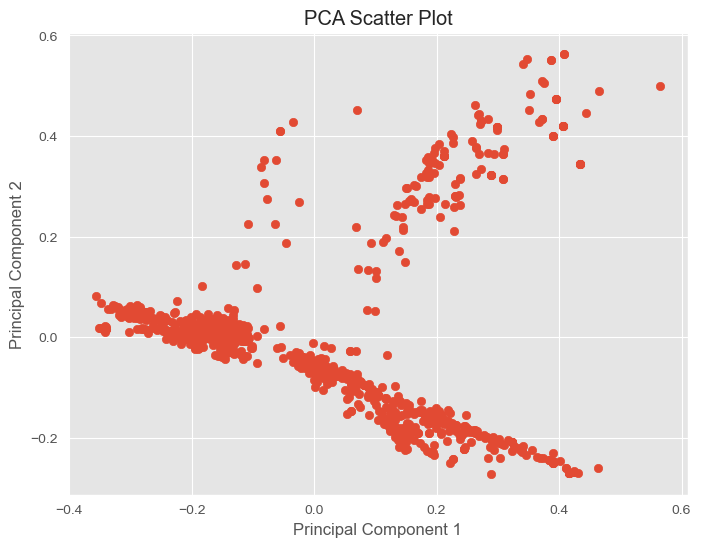

In [130]:
# Plot 
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import pandas as pd

# Sample text data (replace this with your own text data)
text_data = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

# Create TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

# Convert TF-IDF matrix to a DataFrame (optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)  # You can specify the number of components (e.g., 2 for 2D visualization)
tsne_results = tsne.fit_transform(tfidf_matrix)

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

# Example data
n_samples = 100
n_features = 10

# Generating random data
random_data = np.random.rand(n_samples, n_features)

# Initialize t-SNE with different perplexity values
perplexities = [5, 20, 50, 100]

for perplexity in perplexities:
    tsne = TSNE(n_components=2, perplexity=perplexity)
    tsne_results = tsne.fit_transform(random_data)
    print(f"Perplexity: {perplexity}, t-SNE shape: {tsne_results.shape}")

In [54]:
# Encodage des catégories pour colorer le tracé t-SNE

# Créer une instance de LabelEncoder
label_encoder = LabelEncoder()

# Entrainer et transformer la colonne « catégorie »
df['category_encoded'] = label_encoder.fit_transform(df['category'])

In [131]:
# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_tsne_tfidf['TSNE1'], df_tsne_tfidf['TSNE2'], c=df['category_encoded'], cmap='rainbow')

# Adding legend based on the 'category' column
handles, labels = scatter.legend_elements()
legend = plt.legend(handles, df_image['category'].unique(), title='Categories', bbox_to_anchor=(1,1), loc='upper left')
legend.get_title().set_fontweight('bold')

# Adding details
plt.xlabel('t-SNE Component 1', fontweight = 'bold')
plt.ylabel('t-SNE Component 2', fontweight = 'bold')
plt.title('t-SNE Scatter Plot of real categories', fontweight ='bold', fontsize=18)
plt.show()

In [ ]:
# Plot with a different color for each cluster 
colors = random_colors(7) # Randomly selects 7 colors for the graph 

plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(cluster_labels_tf)):
    cluster_indices = np.where(cluster_labels_tf == label)
    sns.scatterplot(data=df_tsne_tfidf.loc[cluster_indices], x='TSNE1', y='TSNE2', color=colors[i], label=f'Cluster {label}')

# Adding the details
plt.xlabel('t-SNE Component 1', fontweight ='bold')
plt.ylabel('t-SNE Component 2', fontweight ='bold')
plt.title('t-SNE scatter plot of clusters', fontweight ='bold', fontsize=18)

# Moving the legend outside of the graph
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Clusters')
legend = plt.gca().get_legend()
legend.get_title().set_fontweight('bold')

plt.show()